# Домашнее задание 9. Настройка композиций алгоритмов

В этом задании вы настроите случайный лес, градиентный бустинг, а также их композицию на данных
соревнования [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

Данные загружаются сразу из гитхаба ниже.

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных.

## Загрузка данных

In [3]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [4]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


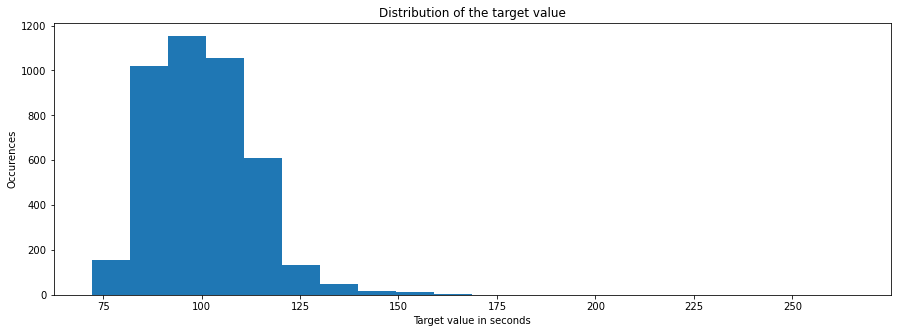

In [5]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [6]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [7]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

<ipython-input-7-86fbcd4c84a1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[column] = x_train[column].apply(mapper)


,X147,X368,X132,X279,X328,X55,X256,X35,X358,X205,...,X198,X21,X105,X33,X86,X326,X29,X174,X130,X14
0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,1,1,0,0
4,0,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [12]:
x_train.shape, y_train.shape

((4209, 376), (4209,))

In [13]:
from sklearn.utils import shuffle

In [14]:
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [15]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 376), (2000,))

In [16]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 376), (1000,))

In [17]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 376), (1209,))

## Настройка моделей

На занятиях мы обсуждали, что поскольку случайный лес и градиентный бустинг разрабатывались исходя из разных принципов, то и базовые алгоритмы - решающие деревья - им нужны разные. Отсюда вытекает, что какие-то гиперапараметры более важны, а какие-то - менее важны для каждого из этих алгоритмов. Для каждого из алгоритмов мы будем сначала подбирать наиболее важные для него гиперапраметры, а затем - втоостепенные.

Для случайного леса самый важный гиперпараметр - max_features (сколько случайно выбранных признаков перебирать при построении вершины), потому что он влияет на то, насколько различными будут деревья (а это основная идея случайного леса). В частности, если вы меняете признаковое пространство (а значит, и число признаков), то этот гиперпараметр надо подбирать заново. После настройки max_features подбираются остальные гиперпараметры.

Для градиентного бустинга самые важные гиперпараметры - число деревьев и глубина дерева. Глубина дерева задает, насколько слабыми или сильными будут отдельные деревья, а значит и то, насколько мы будем двигаться в сторону градиента. После этих гиперпараметров подбирают другие гиперпараметры. 

In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

В этой части вам надо найти оптимальные гиперпараметры для случайного леса и градиентного бустинга, используя первую часть выборки (x1, y1).

__Задание 1.__
Начнем со случайного леса. 
1. (уже сделано ниже) Постройте график зависимости качества от числа деревьев в случайном лесе на кросс-валидации с 3 блоками. Выберите число деревьев для использования в дальнейшей настройке и при итоговом обучении модели.
1. __(1.25 балла)__ Постройте график зависимости качества от max_features на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1. __(1.25 балла)__ С помощью кросс-валидации выберите оптимальные значения для max_depth, min_samples_leaf, min_samples_split. В этом пункте не нужно строить график, только выбрать лучшее значение. Обратите внимание, что в этом пункте нужно использовать max_features, выбранное на предыдущем шаге.
1. __(0.5 балла)__ Обучите случайный лес с выбранными гиперпараметрами на всей выборке x1, y1.

Указания: verbose=3 в GridSearchCV будет выводить значения качества на каждой обучаемой модели. Рекомендуется в экспериментах зафиксировать random_state у модели. Если вы перезапускаете ядро, старайтесь не перезапускать все ячейки перебора гиперпараметров (они могут долго считаться, кроме того, могут измениться оптимальные гиперпараметры, если вы не везде зафиксировали random state), перезапускайте только те ячейки, результаты которых используются дальше. В данном блоке это только ячейка, отвечающая за последний пункт (итоговое обучение случайного леса).

Если вдруг получилось, что вы перезапустили ячейки с grid search, и у вас изменились оптимальные гиперпараметры, при этом ранее полученные гиперпараметры уже использованы ниже в ноутбуке, напишите об этом пояснение и не переделывайте другие задания.

In [35]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, scoring='r2', verbose=3)

In [36]:
gs.fit(x1, y1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ....................n_estimators=1;, score=0.171 total time=   0.0s
[CV 2/5] END ...................n_estimators=1;, score=-0.747 total time=   0.0s
[CV 3/5] END ...................n_estimators=1;, score=-0.028 total time=   0.0s
[CV 4/5] END ...................n_estimators=1;, score=-0.098 total time=   0.0s
[CV 5/5] END ....................n_estimators=1;, score=0.043 total time=   0.0s
[CV 1/5] END ....................n_estimators=2;, score=0.339 total time=   0.0s
[CV 2/5] END ....................n_estimators=2;, score=0.087 total time=   0.0s
[CV 3/5] END ....................n_estimators=2;, score=0.302 total time=   0.0s
[CV 4/5] END ....................n_estimators=2;, score=0.044 total time=   0.0s
[CV 5/5] END ....................n_estimators=2;, score=0.127 total time=   0.0s
[CV 1/5] END ....................n_estimators=4;, score=0.372 total time=   0.1s
[CV 2/5] END ....................n_estimators=4;

GridSearchCV(estimator=RandomForestRegressor(random_state=1, warm_start=True),
             param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)},
             scoring='r2', verbose=3)

Text(0, 0.5, 'R2')

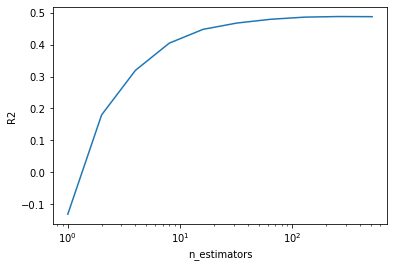

In [37]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже более-менее приналежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

In [38]:
# базовая логарифмическая шкала для max_features
param_grid = {"max_features":2**np.arange(1, 9)}

In [39]:
gs1 = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=1, warm_start=True), param_grid, scoring='r2', verbose=3)

In [40]:
gs1.fit(x1, y1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ....................max_features=2;, score=0.418 total time=   0.6s
[CV 2/5] END ....................max_features=2;, score=0.510 total time=   0.7s
[CV 3/5] END ....................max_features=2;, score=0.570 total time=   0.8s
[CV 4/5] END ....................max_features=2;, score=0.253 total time=   0.7s
[CV 5/5] END ....................max_features=2;, score=0.382 total time=   0.6s
[CV 1/5] END ....................max_features=4;, score=0.437 total time=   0.6s
[CV 2/5] END ....................max_features=4;, score=0.525 total time=   0.6s
[CV 3/5] END ....................max_features=4;, score=0.600 total time=   0.6s
[CV 4/5] END ....................max_features=4;, score=0.283 total time=   0.6s
[CV 5/5] END ....................max_features=4;, score=0.421 total time=   0.6s
[CV 1/5] END ....................max_features=8;, score=0.447 total time=   0.7s
[CV 2/5] END ....................max_features=8;,

GridSearchCV(estimator=RandomForestRegressor(random_state=1, warm_start=True),
             param_grid={'max_features': array([  2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)},
             scoring='r2', verbose=3)

Text(0, 0.5, 'R2')

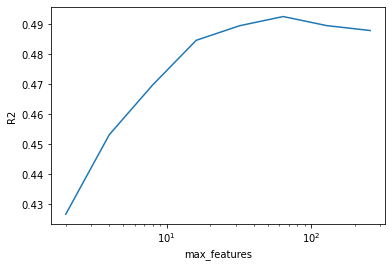

In [41]:
plt.plot((param_grid["max_features"]), gs1.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("max_features")
plt.ylabel("R2")

In [43]:
maxim = -1
max_feat = None
for i in zip(gs1.cv_results_['mean_test_score'], gs1.cv_results_['param_max_features']):
    if i[0] > maxim:
        maxim = i[0]
        max_feat = i[1]

#### Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра: <br>

Поведение стандартно, так как сначала увеличение параметра _max_features_ повышает качество модели, однако при достаточно большом пороге качество начинает снижаться, так как начинает происходить переобучение!<br>
Оптимальное значение гиперпараметра _max_features_ - **64**. 

In [48]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_depth":np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], "min_samples_split":[3, 9, 27, 81]}

In [49]:
gs2 = GridSearchCV(RandomForestRegressor(n_estimators=100, max_features=max_feat, random_state=1, warm_start=True), param_grid, scoring='r2', verbose=3)

In [50]:
gs2.fit(x1, y1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.296 total time=   0.2s
[CV 2/5] END max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.361 total time=   0.1s
[CV 3/5] END max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.368 total time=   0.2s
[CV 4/5] END max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.205 total time=   0.1s
[CV 5/5] END max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.300 total time=   0.2s
[CV 1/5] END max_depth=1, min_samples_leaf=1, min_samples_split=9;, score=0.296 total time=   0.1s
[CV 2/5] END max_depth=1, min_samples_leaf=1, min_samples_split=9;, score=0.361 total time=   0.1s
[CV 3/5] END max_depth=1, min_samples_leaf=1, min_samples_split=9;, score=0.368 total time=   0.1s
[CV 4/5] END max_depth=1, min_samples_leaf=1, min_samples_split=9;, score=0.205 total time=   0.1s
[CV 5/5] END max_depth=1, min_samples_leaf=1, m

GridSearchCV(estimator=RandomForestRegressor(max_features=64, random_state=1,
                                             warm_start=True),
             param_grid={'max_depth': array([1, 3, 5, 7]),
                         'min_samples_leaf': [1, 3, 9, 27],
                         'min_samples_split': [3, 9, 27, 81]},
             scoring='r2', verbose=3)

In [51]:
maxim = -1
depth = None
samples_leaf = None
samples_split = None
for i in zip(gs2.cv_results_['mean_test_score'], gs2.cv_results_['param_max_depth'], gs2.cv_results_['param_min_samples_leaf'], gs2.cv_results_['param_min_samples_split']):
    if i[0] > maxim:
        maxim = i[0]
        depth = i[1]
        samples_leaf = i[2]
        samples_split = i[3]

Оптимальные значения параметров:
* _min_samples_split_ - **81**
* _min_samples_leaf_ - **1**
* _max_depth_ - **7**

In [52]:
tree = RandomForestRegressor(n_estimators=500, max_features=max_feat, max_depth=depth, min_samples_leaf=samples_leaf, min_samples_split=samples_split, random_state=1, warm_start=True)

In [53]:
tree.fit(x1, y1)

RandomForestRegressor(max_depth=7, max_features=64, min_samples_split=81,
                      n_estimators=500, random_state=1, warm_start=True)

__Задание 2.__

Теперь настроим градиентный бустинг, используя ту же выборку x1, y1.

1.  __(1.5 балла)__ Запустите кросс-валидацию для GradentBoostingRegressor по n_estimators и learning_rate. Постройте двумерный график или несколько одномерных (например, график качество-число деревьев при разных значениях длины шага). При построении графиков используйте логарифмическую шкалу по оси абсцисс (вызовите np.log2 или используйте plt.xscale("log")). Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите значения для использования при дальнейшей настройке и для финального обучения модели.
1.  __(1.25 балла)__ Постройте график зависимости качества от max_depth на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1.  __(1.25 балла)__ Выберите оптимальные значения для min_samples_split, min_samples_leaf, max_features с помощью кросс-валидации. В этом пункте не нужно строить график. Обратите внимание, что в этом пункте нужно исползьзовать ранее выбранные гиперпараметры.
1.  __(0.5 балла)__ Обучите итоговую модель с выбранными значениями гиперпараметров на всей выборке x1, y1.

Примеры построения трехмерных графиков [здесь](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

In [18]:
# базовая шкала для числа деревьев и длины шага
param_grid = {"n_estimators":2**np.arange(10), "learning_rate":0.1**np.arange(5)}
gs3 = GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start=True), param_grid, scoring='r2', verbose=3)

In [19]:
gs3.fit(x1, y1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END .learning_rate=1.0, n_estimators=1;, score=0.524 total time=   0.0s
[CV 2/5] END .learning_rate=1.0, n_estimators=1;, score=0.627 total time=   0.0s
[CV 3/5] END .learning_rate=1.0, n_estimators=1;, score=0.702 total time=   0.0s
[CV 4/5] END .learning_rate=1.0, n_estimators=1;, score=0.381 total time=   0.0s
[CV 5/5] END .learning_rate=1.0, n_estimators=1;, score=0.488 total time=   0.0s
[CV 1/5] END .learning_rate=1.0, n_estimators=2;, score=0.528 total time=   0.0s
[CV 2/5] END .learning_rate=1.0, n_estimators=2;, score=0.627 total time=   0.0s
[CV 3/5] END .learning_rate=1.0, n_estimators=2;, score=0.680 total time=   0.0s
[CV 4/5] END .learning_rate=1.0, n_estimators=2;, score=0.368 total time=   0.0s
[CV 5/5] END .learning_rate=1.0, n_estimators=2;, score=0.492 total time=   0.0s
[CV 1/5] END .learning_rate=1.0, n_estimators=4;, score=0.527 total time=   0.0s
[CV 2/5] END .learning_rate=1.0, n_estimators=4

GridSearchCV(estimator=GradientBoostingRegressor(random_state=1,
                                                 warm_start=True),
             param_grid={'learning_rate': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04]),
                         'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)},
             scoring='r2', verbose=3)

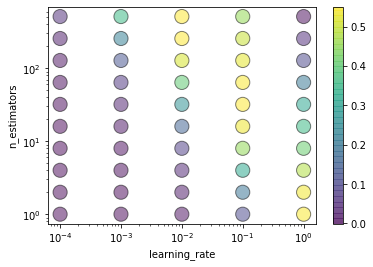

In [23]:
fig = plt.figure()
plt.scatter(gs3.cv_results_['param_learning_rate'].data, gs3.cv_results_['param_n_estimators'].data, 
           linewidths=1, alpha=.5,
           edgecolor='k',
           s = 200,
           c=gs3.cv_results_['mean_test_score'])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("learning_rate")
plt.ylabel("n_estimators")
plt.colorbar()
plt.show()

In [28]:
maxim = -1
n_estim = None
learning_r = None
for i in zip(gs3.cv_results_['mean_test_score'], gs3.cv_results_['param_n_estimators'], gs3.cv_results_['param_learning_rate']):
    if i[0] > maxim:
        maxim = i[0]
        n_estim = i[1]
        learning_r = i[2]

##### Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите значения для использования при дальнейшей настройке и для финального обучения модели. <br>

Результат стандартный, так как, чем больше времени у модели на обучение (т. е. чем больше _learning_rate_), тем меньше ей должно требоваться деревьев для эффективного обучения (т. е. тем меньше _n_estimators_). При этом, как и всегда, если деревьев становится слишком много, происходит переобучение и эффективность качества модели снижается. <br>

Оптимальные значения параметров:
* _learning_rate_ - **0.01**
* _n_estimators_ - **512**

In [29]:
# базовая шкала для max_depth
param_grid = {"max_depth":np.arange(1, 9)}
gs4 = GridSearchCV(GradientBoostingRegressor(learning_rate=learning_r, n_estimators=n_estim, random_state=1, warm_start=True), param_grid, scoring='r2', verbose=3)

In [30]:
gs4.fit(x1, y1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .......................max_depth=1;, score=0.486 total time=   2.0s
[CV 2/5] END .......................max_depth=1;, score=0.591 total time=   2.0s
[CV 3/5] END .......................max_depth=1;, score=0.649 total time=   2.0s
[CV 4/5] END .......................max_depth=1;, score=0.340 total time=   2.2s
[CV 5/5] END .......................max_depth=1;, score=0.493 total time=   2.0s
[CV 1/5] END .......................max_depth=2;, score=0.529 total time=   4.0s
[CV 2/5] END .......................max_depth=2;, score=0.644 total time=   3.9s
[CV 3/5] END .......................max_depth=2;, score=0.702 total time=   4.2s
[CV 4/5] END .......................max_depth=2;, score=0.375 total time=   4.1s
[CV 5/5] END .......................max_depth=2;, score=0.529 total time=   3.8s
[CV 1/5] END .......................max_depth=3;, score=0.528 total time=   5.8s
[CV 2/5] END .......................max_depth=3;,

GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.010000000000000002,
                                                 n_estimators=512,
                                                 random_state=1,
                                                 warm_start=True),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])},
             scoring='r2', verbose=3)

Text(0, 0.5, 'R2')

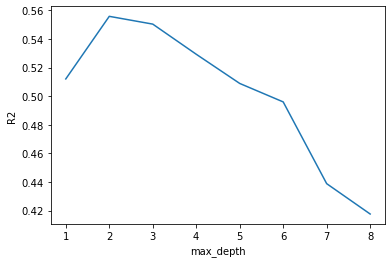

In [32]:
plt.plot((param_grid["max_depth"]), gs4.cv_results_['mean_test_score'])
plt.xlabel("max_depth")
plt.ylabel("R2")

##### Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.<br>

Результат кажется логичным, так как при решающих пнях (т. е. _max_depth_ равному единице) качество модели достаточно низкое. Дальше оно должно повышаться с увеличением максимальной глубины, а затем снижаться из-за переобучения. В целом, на этом графике все так и происходит, единственное, что максимума качества мы достигаем не при дефолтном значении _max_depth_ равном тройке.<br>

Оптимальное значение гиперпараметра _max_depth_ - **2**

In [33]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}
gs5 = GridSearchCV(GradientBoostingRegressor(learning_rate=learning_r, n_estimators=n_estim, max_depth=2, random_state=1, warm_start=True), param_grid, scoring='r2', verbose=3)

In [34]:
gs5.fit(x1, y1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END max_features=2, min_samples_leaf=1, min_samples_split=3;, score=0.294 total time=   0.1s
[CV 2/5] END max_features=2, min_samples_leaf=1, min_samples_split=3;, score=0.370 total time=   0.1s
[CV 3/5] END max_features=2, min_samples_leaf=1, min_samples_split=3;, score=0.397 total time=   0.1s
[CV 4/5] END max_features=2, min_samples_leaf=1, min_samples_split=3;, score=0.199 total time=   0.1s
[CV 5/5] END max_features=2, min_samples_leaf=1, min_samples_split=3;, score=0.290 total time=   0.1s
[CV 1/5] END max_features=2, min_samples_leaf=1, min_samples_split=9;, score=0.294 total time=   0.1s
[CV 2/5] END max_features=2, min_samples_leaf=1, min_samples_split=9;, score=0.370 total time=   0.1s
[CV 3/5] END max_features=2, min_samples_leaf=1, min_samples_split=9;, score=0.397 total time=   0.1s
[CV 4/5] END max_features=2, min_samples_leaf=1, min_samples_split=9;, score=0.199 total time=   0.1s
[CV 5/5] END max_fea

GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.010000000000000002,
                                                 max_depth=2, n_estimators=512,
                                                 random_state=1,
                                                 warm_start=True),
             param_grid={'max_features': array([  2,   8,  32, 128], dtype=int32),
                         'min_samples_leaf': [1, 3, 9, 27],
                         'min_samples_split': [3, 9, 27, 81]},
             scoring='r2', verbose=3)

In [54]:
maxim = -1
features = None
samples_leafs = None
samples_splits = None
for i in zip(gs5.cv_results_['mean_test_score'], gs5.cv_results_['param_max_features'], gs5.cv_results_['param_min_samples_leaf'], gs5.cv_results_['param_min_samples_split']):
    if i[0] > maxim:
        maxim = i[0]
        features = i[1]
        samples_leafs = i[2]
        samples_splits = i[3]

Оптимальные значения параметров:
* _max_features_ - **128**
* _min_samples_leaf_ - **9**
* _max_depth_ - **2**

In [55]:
gb = GradientBoostingRegressor(learning_rate=learning_r, n_estimators=n_estim, max_depth=2, max_features=features, min_samples_leaf=samples_leafs, min_samples_split=samples_splits, random_state=1, warm_start=True)

In [56]:
gb.fit(x1, y1)

GradientBoostingRegressor(learning_rate=0.010000000000000002, max_depth=2,
                          max_features=128, min_samples_leaf=9,
                          min_samples_split=81, n_estimators=512,
                          random_state=1, warm_start=True)

__Задание 3.__

 __(1 балл)__ Выведите качество случайного леса и градиентного бустинга на x2, y2, а также качество модели, представляющей собой усреднение предсказаний двух обученных моделей. Какой из трех вариантов работает лучше?

In [121]:
print(f'Качество случайного леса равно {tree.score(x2, y2)}')

Качество случайного леса равно 0.556449502555437


In [122]:
print(f'Качество градиентного бустинга равно {gb.score(x2, y2)}')

Качество градиентного бустинга равно 0.5621075126858015


In [129]:
from sklearn.metrics import r2_score
preds_tree = tree.predict(x2)
preds_gb = gb.predict(x2)
preds_average = np.average(np.hstack((preds_tree.reshape(-1, 1), preds_gb.reshape(-1, 1))), axis=1)
print(f'Качество модели, представляющей собой усреднение предсказаний двух обученных моделей равно {r2_score(y2, preds_average)}')

Качество модели, представляющей собой усреднение предсказаний двух обученных моделей равно 0.5604696959922962


##### Какой из трех вариантов работает лучше? <br>

Лучше всего работает **градиентный бустинг**!

__Задание 4.__

 __(1 балл)__  Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [77]:
from sklearn.linear_model import LinearRegression

In [130]:
meta_X = np.hstack((preds_tree.reshape(-1, 1), preds_gb.reshape(-1, 1)))

In [106]:
blender = LinearRegression()

In [107]:
blender.fit(meta_X, y2)

LinearRegression()

__Задание 5.__

 __(0.5 балла)__ Выведите качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга. Какая из четырех моделей работает лучше? Работает ли блендинг лучше усреднения? Выведите веса блендинга, какой из базовых алгоритмов вносит большой вклад в итоговую модель?

In [132]:
print(f'Качество случайного леса равно {tree.score(x3, y3)}')

Качество случайного леса равно 0.6122604181520519


In [133]:
print(f'Качество градиентного бустинга равно {gb.score(x3, y3)}')

Качество градиентного бустинга равно 0.6149062261083993


In [134]:
pred_tree = tree.predict(x3)
pred_gb = gb.predict(x3)
pred_average = np.average(np.hstack((pred_tree.reshape(-1, 1), pred_gb.reshape(-1, 1))), axis=1)
print(f'Качество модели, представляющей собой усреднение предсказаний двух обученных моделей равно {r2_score(y3, pred_average)}')

Качество модели, представляющей собой усреднение предсказаний двух обученных моделей равно 0.6147501453268438


In [135]:
meta_X_new = np.hstack((pred_tree.reshape(-1, 1), pred_gb.reshape(-1, 1)))

In [144]:
print(f'Качество блендинга равно {blender.score(meta_X_new, y3)}')

Качество блендинга равно 0.6174466032292583


##### Какая из четырех моделей работает лучше? Работает ли блендинг лучше усреднения?<br>

Из всех моделей самое высокое качество у **блендинга**, так что понятно, что он работает и лучше усреденения

In [145]:
print(f'Веса блендинга равны {blender.coef_}')

Веса блендинга равны [-0.38607839  1.47322099]


##### Какой из базовых алгоритмов вносит большой вклад в итоговую модель?<br>

Больший вклад в итоговую модель вносит второй базовый алгоритм, т. е. **градиентный бустинг**!